## Plotting W&B Curves using matplotlib

- The data is being downloaded from wandb.
- Some parameters (e.g. group names and baselines) and environment details are hardcoded for my personal experiments ran on SMAC, please adjust as needed.
- The plotting functions assume that everything that's plotted in a single graph belongs in a single wandb group. Therefore you might have to move things around either using the GUI on wandb.ai or programmatically.

In [5]:
import wandb
import pandas as pd
import numpy as np
api = wandb.Api(timeout=20)

runs = api.runs("oxwhirl/smac-v2-final-runs")

In [6]:
groups = "stochastic-trial"
baselines=["baseline", "open_loop"]

In [7]:
def get_empty_results_dict(env_names, baselines):
    results = {}
    for env in env_names:
        results[env] = {}
        for method in baselines:
            results[env][method] = []
    return results

In [9]:
def get_env_names(group=groups):
    if group == "stochastic-trial":
        return ["6h_vs_8z", "27m_vs_30m", "5m_vs_6m", "8m_vs_9m", "bane_vs_bane",
        "3s5z_vs_3s6z", "3s_vs_5z", "corridor", "2c_vs_64zg", "2s_vs_1sc", "2s3z", "3s5z", "10m_vs_11m", "1c3s5z"]
        
def get_algo_from_name(name):
    config_map = {
        "qmix_smac": "QMIX",
        "vdn_smac": "VDN",
        "clipping_rnn_decentral_critic_MAPPO": "MAPPO",
        "clipping_rnn_decentral_critic": "IPPO",
        "ppo_rnn_open_loop": "open_loop",
        "ppo_rnn_baseline": "baseline"
    }
    for k, v in config_map.items():
        if k in name:
            return v
        
def get_env_name_of_run(map_name, group, exp_name):
    if "22Gen" in group:
        # e.g. 10_Protoss, 10_Protoss_Hard
        env_name_map = {
            "10gen_protoss": "10_Protoss",
            "10gen_zerg": "10_Zerg",
            "10gen_terran": "10_Terran",
        }
        env = env_name_map[map_name]
        env += "_Hard" if ("_ood" in group) else ""
        return env
    elif "stochastic-trial" in group:
        return map_name
    else:
        # e.g. 8m_Accuracy, 8m_Health
        env_name = map_name
        if "attack" in exp_name:
            env_name += "_Accuracy"
        if "health" in exp_name:
            env_name += "_Health"
        return env_name
    
metric_map = {
    "test/battle_won_mean": "mean_test_win_rate",
    "test/return_mean": "mean_test_return",
    "train/battle_won_mean": "mean_train_win_rate",
    "train/return_mean": "mean_train_return",
}

metric_train = [key for key in metric_map.keys() if key.startswith("train/")]
metric_test = [key for key in metric_map.keys() if key.startswith("test/")]

In [10]:
from tqdm import tqdm
def get_data(baselines=baselines, group_name=groups, metrics=metric_map.keys(), average=False): 
    # use average=True for train data if contains bug in wandb plotting
    env_names = get_env_names(group_name)
    results = get_empty_results_dict(env_names, baselines)
    
    for run in tqdm(runs):
        if not hasattr(run, "group") or run.group != group_name:
            continue

        run_name = run.name
        map_name = run.config["env_args"]["map_name"]
        
        baseline = get_algo_from_name(run_name)
        if not baseline:
            print(f"oh no {run_name}")
        env = get_env_name_of_run(map_name, group_name, run_name)
        
        data_all = {}
        if True: #run.state == "finished":
            for metric in metrics:
                data = []
                for i, row in run.history(keys=['train/step', metric]).iterrows():
                    data.append([int(row["train/step"]), row[metric]])
                data_all[metric] = data

        df_all = None
        for key in data_all.keys():
            df = pd.DataFrame.from_records(data_all[key])
            df = df.rename(columns={0: "step", 1: metric_map[key]})
            if average and df.shape[0] > 0:
                df = df.groupby('step',as_index=False).mean()
            
            if df_all is None:
                df_all = df
            else:
                try:
                    df_all = pd.merge(df_all, df, on="step")
                except KeyError:
                    continue

        if df_all.shape[0] > 0:
            # Adding generalization gap 
            try:
#                 df_all['return_gap'] = df_all['mean_train_return'] - df_all['mean_test_return']
                results[env][baseline].append(df_all)
            except KeyError:
                # Rare error, seen only once so far
                print("Skipping ", baseline, env)
        else:
            print("Skipping ", baseline, env)
        
    return results

In [13]:
results_10gen_test = get_data(baselines, group_name=groups, metrics=metric_test)

 33%|███▎      | 30/91 [00:27<00:41,  1.45it/s]

oh no ppo_rnn_central_V-10m_vs_11m-44b83c


 34%|███▍      | 31/91 [00:27<00:40,  1.49it/s]

Skipping  None 10m_vs_11m
oh no ppo_rnn_central_V-10m_vs_11m-6a353d


 35%|███▌      | 32/91 [00:28<00:37,  1.56it/s]

Skipping  None 10m_vs_11m
oh no ppo_rnn_central_V-10m_vs_11m-d709b2


 36%|███▋      | 33/91 [00:29<00:38,  1.52it/s]

Skipping  None 10m_vs_11m
oh no ppo_rnn_central_V-3s5z-6ab6b4


 37%|███▋      | 34/91 [00:29<00:36,  1.56it/s]

Skipping  None 3s5z
oh no ppo_rnn_central_V-3s5z-92f6bd


 38%|███▊      | 35/91 [00:30<00:34,  1.62it/s]

Skipping  None 3s5z
oh no ppo_rnn_central_V-3s5z-7df1d9


 40%|███▉      | 36/91 [00:30<00:34,  1.61it/s]

Skipping  None 3s5z
oh no ppo_rnn_central_V-1c3s5z-0d2488


 41%|████      | 37/91 [00:31<00:31,  1.72it/s]

Skipping  None 1c3s5z
oh no ppo_rnn_central_V-1c3s5z-1d2087


 42%|████▏     | 38/91 [00:31<00:32,  1.63it/s]

Skipping  None 1c3s5z
oh no ppo_rnn_central_V-1c3s5z-636880


 43%|████▎     | 39/91 [00:32<00:30,  1.70it/s]

Skipping  None 1c3s5z
oh no ppo_rnn_central_V-2s_vs_1sc-828b25


 44%|████▍     | 40/91 [00:33<00:30,  1.65it/s]

Skipping  None 2s_vs_1sc
oh no ppo_rnn_central_V-2s_vs_1sc-1a47db


 45%|████▌     | 41/91 [00:33<00:31,  1.61it/s]

Skipping  None 2s_vs_1sc
oh no ppo_rnn_central_V-2s_vs_1sc-c0bef6


 46%|████▌     | 42/91 [00:34<00:29,  1.64it/s]

Skipping  None 2s_vs_1sc


 51%|█████     | 46/91 [00:36<00:24,  1.87it/s]

Skipping  baseline 2s3z


 85%|████████▍ | 77/91 [00:59<00:16,  1.14s/it]

Skipping  baseline 10m_vs_11m


 86%|████████▌ | 78/91 [01:00<00:12,  1.02it/s]

Skipping  baseline 10m_vs_11m


 87%|████████▋ | 79/91 [01:00<00:10,  1.16it/s]

Skipping  baseline 10m_vs_11m


 88%|████████▊ | 80/91 [01:01<00:09,  1.20it/s]

Skipping  baseline 3s5z


 89%|████████▉ | 81/91 [01:02<00:08,  1.12it/s]

Skipping  baseline 3s5z


 90%|█████████ | 82/91 [01:03<00:07,  1.21it/s]

Skipping  baseline 3s5z


 91%|█████████ | 83/91 [01:03<00:05,  1.39it/s]

Skipping  baseline 1c3s5z


 92%|█████████▏| 84/91 [01:04<00:04,  1.43it/s]

Skipping  baseline 1c3s5z


 93%|█████████▎| 85/91 [01:05<00:03,  1.50it/s]

Skipping  baseline 1c3s5z


100%|██████████| 91/91 [01:08<00:00,  1.32it/s]


In [12]:
results_10gen_train = get_data(baselines, group_name=groups, metrics=metric_train, average=True)

 51%|█████     | 46/91 [00:37<00:22,  1.96it/s]

Skipping  baseline 2s3z


100%|██████████| 91/91 [01:19<00:00,  1.15it/s]


In [ ]:
# for env in results.keys():
#     for algo in results[env]:
#         print(env, algo, len(results[env][algo]))

# print(results_10gen_train["2s3z"])        
# print(len(results_10gen_test["2s3z"]["baseline"]))
print(results_10gen_train["2s3z"]["baseline"][0][:-20])


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
smooth_params = (11, 1)
sns_colors = sns.color_palette("tab10")
colors_2 = sns.color_palette("Paired")


colors = {"open_loop": sns_colors[0], 
          "baseline": sns_colors[1], 
          "IPPO": sns_colors[2], 
          "MAPPO": sns_colors[3],
          "QMIX(C)": sns_colors[0], 
          "VDN(C)": sns_colors[1], 
          "IPPO(C)": sns_colors[2], 
          "MAPPO(C)": sns_colors[3],
         }
linestyles = {
    "open_loop": "solid", 
    "baseline": "solid", 
    "IPPO": "solid", 
    "MAPPO": "solid",
    "QMIX(C)": "dashed", 
    "VDN(C)": "dashed",
    "IPPO(C)": "dashed", 
    "MAPPO(C)": "dashed",
}

from math import floor

def round_down(num, divisor=10**6):
    return floor(num / divisor) * divisor

def round_str(num):
    num += 900000
    if num > 10**9:
        divisor = 10**9
        letter = 'B'
    else:
        letter = 'M'
        divisor = 10**6
    
    return "{}{}".format(floor(num / divisor), letter)


def plot_run(
    df,
    df_std,
    x,
    y,
    color="#ff0000",
    linestyle="solid",
    subsample=1000,
    xlim=(0, None),
    ylim=(None, None),
    alpha=1,
    alpha_std=0.1,
    ax=None,
    show_labels=True,
    figsize=(3, 4),
    linewidth=1,
    window=10,
):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    df = df[[x, y]].dropna()
    df[y] = df[y].rolling(window, min_periods=0).mean()
    
    xval = np.linspace(0, df[x].max(), subsample)
    yval = np.interp(xval, df[x].values, df[y].values)
    
    ax.plot(xval, yval, c=color, linestyle=linestyle, alpha=alpha, linewidth=linewidth)
    
    # STD
    df_std = df_std[[x, y]].dropna()
    df_std[y] = df_std[y].rolling(window, min_periods=0).mean()
    
    xval_std = np.linspace(0, df_std[x].max(), subsample)
    yval_std = np.interp(xval, df_std[x].values, df_std[y].values)

    ax.fill_between(xval, yval, yval+yval_std, color=color, alpha=alpha_std)
    ax.fill_between(xval, yval, yval-yval_std, color=color, alpha=alpha_std)

    ax.set_xlim(xlim)
#     ax.set_ylim(ylim)
    if show_labels:
        ax.set_xlabel(x)
        ax.set_ylabel(y)
    return yval.max()


def plot_algo(dfs, algo, grid, ax, ylim, x="step", y="mean_train_return", show_labels=True, smoothing=0, estimator='mean'):
    ys = []
    ymax = 0
    for df in dfs:
        try:
            yvalues = np.interp(grid, df[x].values, df[y].values)
        except KeyError: 
            continue
        ys.append(yvalues)
        # Individual runs
#         ymax_cur = plot_run(df, x, y, color=colors[algo], alpha=0.25, ax=ax, ylim=ylim, show_labels=show_labels)
#         ymax_cur = max(ymax_cur, ymax)
     
    if estimator == 'mean':
        y_arr = np.array(ys).mean(0)
    elif estimator == "median":
        y_stack = np.stack(ys)
        y_arr = np.median(y_stack, axis = 0)
    y_std = np.array(ys).std(0)
    
    df = pd.DataFrame({x: grid, y: y_arr})
    df_std = pd.DataFrame({x: grid, y: y_std})
    plot_run(df, df_std, x, y, alpha=1, color=colors[algo], linestyle=linestyles[algo],
             ax=ax, ylim=ylim, show_labels=show_labels, linewidth=2)

def plot_env(results, env, ax=None, x="step", y="mean_train_return", 
             smoothing=0, show_labels=True, estimator='mean', 
             baselines=baselines, max_steps=None, linespace_points=200, 
             val_max=None, 
             val_min=None):
    
    dfs = {}
    for algo in baselines:
        dfs[algo] = [df[[x, y]] for df in results[env][algo]]
    
    if max_steps is None:
        ymax = 0
        for algo in baselines:
            for df in dfs[algo]:
                ymax = max(ymax, df['step'].iloc[-1])
    else:
        ymax = max_steps
    
    if val_max is None:
        val_max = max(df[y].max() for df in dfs[algo] for algo in baselines) * 1.15
    if val_min is None:
        val_min = min(df[y].min() for df in dfs[algo] for algo in baselines) * 1.15

    grid = np.linspace(0, ymax, linespace_points)
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    
    for algo in baselines:
        plot_algo(dfs[algo], algo, grid, ax, y=y, ylim=(val_min,val_max), show_labels=show_labels, estimator=estimator)

    ax.set_title(env, size=15)
    ax.set_xticks([0,round_down(ymax)])
    ax.set_xticklabels(["0", round_str(ymax)])
    

def plot_individual(results, env, y="mean_train_return", estimator="mean",
                    x_label="Step", y_label=None, size=15, graph_w=3, graph_h=3, 
                    y_label_show=True, show=True, **kwargs):
    
    fig, ax = plt.subplots(figsize=(graph_w, graph_h))
    plt.style.use("seaborn-muted")
    plot_env(results, env, ax, y=y, estimator=estimator, **kwargs)
    
    ax.tick_params(axis='x', which='major', labelsize=16, direction="in")
    ax.tick_params(axis='y', which='major', labelsize=12, direction="in")
    ax.set_xlabel(x_label, size=15)
    
    if y_label is None:
        y_label = y.replace("_", " ").title()
    if y_label_show:
        ax.set_ylabel(y_label, size=15)
                          
    plt.show()

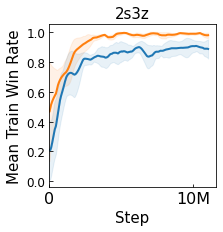

In [14]:
plot_individual(results_10gen_train, "2s3z", y="mean_train_win_rate") #, val_max=1)

In [22]:
# Plots results for many envs on a grid with n columns (n=6 by default)
# For example, if 12 envs are provided, it will print 2 rows x 6 columns
def plot_desired(results, envs, name, y="mean_train_win_rate", grid_size=6, estimator='mean', 
                 graph_w=4, graph_h=3, **kwargs):
    
    rows = len(envs)//grid_size
    x_label="Step"
    size=15
    fig, axs_mat = plt.subplots(rows, grid_size, figsize=(graph_w*grid_size,3*graph_h), 
                                constrained_layout=True, x_label="Step", y_label=None, size=15)
    env_id = 0
    plt.style.use("seaborn-muted")
    
    for row_id, axs in enumerate(axs_mat):
        if env_id >= len(envs):
            break
        
        for i in range(len(axs)):
            if env_id >= len(envs):
                break
            env = envs[env_id]
            env_id += 1
            plot_env(results, env, axs[i], show_labels=False, estimator=estimator, y=y, **kwargs)
            axs[i].tick_params(axis='x', which='major', labelsize=16, direction="in")
            axs[i].tick_params(axis='y', which='major', labelsize=12, direction="in")
            if row_id == len(axs_mat) - 1:
                axs[i].set_xlabel(x_label, size=size)
                
        if y_label is None:
            y_label = y.replace("_", " ").title()
        axs[0].set_ylabel(y_label, size=size)
        
    plt.savefig(name, bbox_inches="")
    
# Plots results several envs 1 one row
def plot_row(results, envs, name, axs=None, start_index=0, estimator='mean', y="mean_test_win_rate", 
             x_label="Step", y_label=None, size=15, graph_w=4, graph_h=3, y_label_show=True, show=True, **kwargs):
    n = len(envs) + start_index
    if axs is None:
        fig, axs = plt.subplots(1, n, figsize=(graph_w*n,graph_h), constrained_layout=True)
    env_id = 0
    plt.style.use("seaborn-muted")

    for i in range(start_index, n):
        if env_id >= len(envs):
            break
        env = envs[env_id]
        env_id += 1
        plot_env(results, env, axs[i], show_labels=False, estimator=estimator, y=y, **kwargs)
        axs[i].tick_params(axis='x', which='major', labelsize=16, direction="in")
        axs[i].tick_params(axis='y', which='major', labelsize=12, direction="in")
        axs[i].set_xlabel(x_label, size=15)
        
        if y_label is None:
            y_label = y.replace("_", " ").title()
        if y_label_show:
            axs[0].set_ylabel(y_label, size=15)
    if show:
        plt.savefig(name, bbox_inches="tight")

In [ ]:
# gs = 6

# n = len(envs_appendix)
# n_grid = gs * (n // gs)
# n_sep = n - n_grid
plot_desired(results, envs_appendix[:n_grid], grid_size=gs, name="navig_app_1.pdf")

In [ ]:
results_ood_train = get_data(baselines, group_name="22Gen_ood", metrics=metric_train, average=True)
results_ood_test = get_data(baselines, group_name="22Gen_ood", metrics=metric_test)

In [ ]:
# Compute generalization Gap
def get_generalization_gap(results_train, results_test):
    assert results_train.keys() == results_test.keys()
    
    envs = list(results_train.keys())
    baselines = list(results_train[envs[0]].keys())
    
    new_results = get_empty_results_dict(envs, baselines)
    for env in envs:
        for method in results_train[env].keys():
            train_runs = results_train[env][method]            
            test_runs = results_test[env][method]
            
            if len(train_runs) != len(test_runs):
                train_runs_new = []
                test_runs_new = []
                print(env, method)
                print(len(results_train[env][method]))
                print(len(results_test[env][method]))
                for i in range(len(train_runs)):
                    df_train = train_runs[i]
                    t_train = set(df_train["step"].tolist())
                    for j in range(len(test_runs)):
                        df_test = test_runs[j]
                        t_test = set(df_test["step"].tolist())
                        x = set.intersection(t_test, t_train)
                        if len(x) > 100:
                            train_runs_new.append(df_train)
                            test_runs_new.append(df_test)
#                         print(i, j, len(x))
                train_runs = train_runs_new
                test_runs = test_runs_new
            
            for i in range(len(train_runs)):
                df_train = train_runs[i] 
                df_test = test_runs[i]
                
                df_all = pd.merge(df_test, df_train, on="step", how="inner")
#                 print(df_all[:15])
                df_all['return_gap'] = df_all['mean_train_return'] - df_all['mean_test_return']
#                 print(df_all[:15])
                new_results[env][method].append(df_all)
                
    return new_results

In [ ]:
all_results_10_gen_test = {**results_10gen_test, **results_ood_test}
all_results_10_gen_train = {**results_10gen_train, **results_ood_train}

result_gap = get_generalization_gap(all_results_10_gen_test, all_results_10_gen_train)

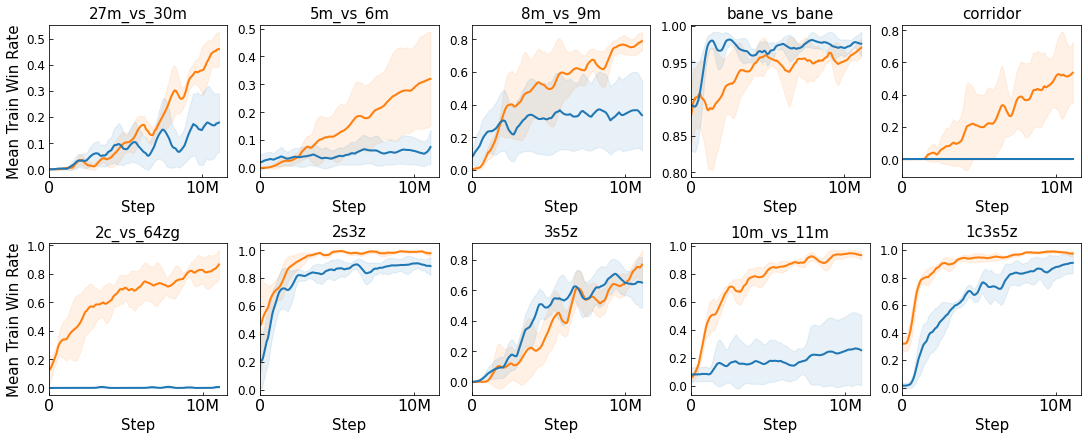

In [30]:
# envs_10gen = ["10_Protoss", "10_Protoss_Hard", "10_Zerg", "10_Zerg_Hard", "10_Terran", "10_Terran_Hard"]
envs = ["27m_vs_30m", "5m_vs_6m", "8m_vs_9m", "bane_vs_bane","corridor"] 
envs_2 = ["2c_vs_64zg", "2s3z", "3s5z", "10m_vs_11m", "1c3s5z"]
# plot_row(all_results_10_gen_test, envs_10gen, estimator='mean', name="10gen_test_return.pdf", y="mean_test_return", graph_w=3, graph_h=3)
# plot_row(all_results_10_gen_train, envs_10gen, estimator='mean', name="10gen_train_return.pdf", y="mean_train_return", graph_w=3, graph_h=3)
# plot_row(result_gap, envs_10gen, estimator='mean', name="10gen_gap.pdf", y="return_gap", graph_w=3, graph_h=3)

# Hacky way to join two rows together
n=5
graph_w=3
graph_h=6
fig, axs = plt.subplots(2, n, figsize=(graph_w*n,graph_h), constrained_layout=True)

plot_row(results_10gen_train, envs, estimator='mean', name="stochastic_win_rate.pdf", axs=axs[0], y="mean_train_win_rate", graph_w=3, graph_h=3)
plot_row(results_10gen_train, envs_2, estimator='mean', name="stochastic_win_rate.pdf", axs=axs[1], y="mean_train_win_rate", graph_w=3, graph_h=3)
# envs_main = ["10_Protoss", "10_Zerg", "10_Terran"]
# plot_row(results_10gen_test, envs_main, estimator='mean', axs=axs, name="10_gen_win_rate.pdf", y="mean_test_win_rate")
# envs_ood = ["10_Protoss_Hard", "10_Zerg_Hard", "10_Terran_Hard"]
# plot_row(results_ood_test, envs_ood, estimator='mean', axs=axs, start_index=3, name="10_gen_win_rate.pdf", y="mean_test_win_rate")

In [ ]:
results_attack_health_train = get_data(baselines, group_name="24Gen", metrics=metric_train, average=True)
results_attack_health_test = get_data(baselines, group_name="24Gen", metrics=metric_test)

In [ ]:
result_gap_attack = get_generalization_gap(results_attack_health_test, results_attack_health_train)

In [ ]:
envs_acc_hp = ["8m_Accuracy", "8m_Health", "3m_Accuracy", "3m_Health",
               "3s5z_Accuracy", "3s5z_Health"]
plot_row(results_attack_health_test, envs_acc_hp, estimator='mean', name="attack_health_win_rate.pdf", y="mean_test_win_rate", graph_w=3, graph_h=3)
plot_row(results_attack_health_test, envs_acc_hp, estimator='mean', name="attack_health_test_return.pdf", y="mean_test_return", graph_w=3, graph_h=3)
plot_row(results_attack_health_train, envs_acc_hp, estimator='mean', name="attack_health_train_return.pdf", y="mean_train_return", graph_w=3, graph_h=3)
plot_row(result_gap_attack, envs_acc_hp, estimator='mean', name="attack_health_gap.pdf", y="return_gap", graph_w=3, graph_h=3)
# plot_row(results_attack_health, envs_acc_hp, estimator='mean', name="attack_health2.pdf", y="mean_test_return",  graph_w=4, graph_h=3)
# plot_row(results_attack_health, envs_acc_hp, estimator='mean', name="attack_health3.pdf", y="mean_train_return",  graph_w=4, graph_h=3)
# plot_row(results_attack_health, envs_acc_hp, estimator='mean', name="attack_health4.pdf", y="return_gap", graph_w=4, graph_h=3)

In [ ]:
envs_acc = ["8m_Accuracy", "3m_Accuracy", "3s5z_Accuracy", "8m_vs_9m_Accuracy", "10m_vs_11m_Accuracy"]
envs_health = ["8m_Health", "3m_Health", "3s5z_Health", "8m_vs_9m_Health", "10m_vs_11m_Health"]

plot_row(results_attack_health_test, envs_acc, estimator='mean', name="attack_win_rate.pdf", y="mean_test_win_rate", graph_w=3, graph_h=3, size=8)
plot_row(results_attack_health_test, envs_acc, estimator='mean', name="attack_test_return.pdf", y="mean_test_return", graph_w=3, graph_h=3)
plot_row(results_attack_health_train, envs_acc, estimator='mean', name="attack_train_return.pdf", y="mean_train_return", graph_w=3, graph_h=3)
plot_row(result_gap_attack, envs_acc, estimator='mean', name="attack_gap.pdf", y="return_gap", graph_w=3, graph_h=3)

plot_row(results_attack_health_test, envs_health, estimator='mean', name="health_win_rate.pdf", y="mean_test_win_rate", graph_w=3, graph_h=3, size=8)
plot_row(results_attack_health_test, envs_health, estimator='mean', name="health_test_return.pdf", y="mean_test_return", graph_w=3, graph_h=3)
plot_row(results_attack_health_train, envs_health, estimator='mean', name="health_train_return.pdf", y="mean_train_return", graph_w=3, graph_h=3)
plot_row(result_gap_attack, envs_health, estimator='mean', name="health_gap.pdf", y="return_gap", graph_w=3, graph_h=3)

In [ ]:
# SAVING TO PICKLE
# import pickle
# print(pickle.format_version)
# print(pickle.HIGHEST_PROTOCOL)

# results_three = (results, results_skill, results_port)
# with open('results_triple.pkl', 'wb') as handle:
#     pickle.dump(results_three, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Legend 

All of the graphs above are legendless. I prefer having a separate thin (1 or 2 line) legend on top of the graphs.
I cut it from this custom graph (not ideal I know).

In [ ]:
# Hacky way to make a independent legend
colors2 = {"QMIX": sns_colors[0], 
          "QMIX(C)": sns_colors[0], 
          "VDN": sns_colors[1], 
          "VDN(C)": sns_colors[1], 
          "IPPO": sns_colors[2], 
          "IPPO(C)": sns_colors[2], 
          "MAPPO": sns_colors[3],
          "MAPPO(C)": sns_colors[3],
         }
linestyles2 = {
    "QMIX": "solid", 
    "QMIX(C)": "dotted", 
    "VDN": "solid", 
    "IPPO": "solid", 
    "MAPPO": "solid",
    "VDN(C)": "dotted",
    "IPPO(C)": "dotted", 
    "MAPPO(C)": "dotted",
}

from matplotlib.lines import Line2D

custom_lines = [Line2D([0],[0], color=colors2[algo], linestyle=linestyles[algo], lw=4) 
                for algo in ["QMIX", "VDN", "IPPO", "MAPPO", "QMIX(C)", "VDN(C)", "IPPO(C)", "MAPPO(C)"]]

fig, ax = plt.subplots(figsize=(20, 4))
lines = ax.plot([1, 1, 2,])
plt.legend(custom_lines, baselines, handlelength=3.5, frameon=False, ncol=4)
plt.savefig("legend.pdf", bbox_inches="tight")